# DME proof of concept

### Libraries

In [1]:
import numpy as np
from scipy.linalg import expm
from collections import defaultdict
from IPython.display import display

from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit.circuit.library.data_preparation import StatePreparation

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, StatePreparation, UnitaryGate
from qiskit.quantum_info import partial_trace, DensityMatrix, Operator, state_fidelity
import matplotlib.pyplot as plt

## Density matrix stuff

In [2]:
def generate_density_matrix(dim):
    """
    Generates a random valid qubit-compatible density matrix of dimension 2^n × 2^n.
    If the requested dim is not a power of 2, the matrix is padded accordingly.

    Args:
        dim (int): Desired matrix dimension (not necessarily a power of 2)

    Returns:
        DensityMatrix: A padded Qiskit DensityMatrix object
    """
    # Generate a random complex matrix
    A = np.random.rand(dim, dim) + 1j * np.random.rand(dim, dim)
    rho = A @ A.conj().T  # Make Hermitian & PSD
    rho /= np.trace(rho)  # Normalize to make it trace 1

    # If not already a power of 2, pad to next power
    next_pow = 2**int(np.ceil(np.log2(dim)))
    if next_pow != dim:
        padded = np.zeros((next_pow, next_pow), dtype=complex)
        padded[:dim, :dim] = rho
        rho = padded
        rho /= np.trace(rho)  # Renormalize after padding

    return DensityMatrix(rho)

def n_tuplicate(rho, n):
    """
    Returns a system state composed of (n+1) copies of the density matrix ρ
    via tensor product: ρ ⊗ ρ ⊗ ... ⊗ ρ

    Args:
        rho (DensityMatrix): The base density matrix.
        n (int): Number of additional copies to tensor with.

    Returns:
        DensityMatrix: The full system state ρ^(⊗(n+1)).
    """
    rho_total = rho
    for _ in range(n):
        rho_total = rho_total.tensor(rho)  # Tensor ⊗ with itself
    return rho_total

def evol_and_trace(rho, qc, tr_idx):
    """
    Evolves a system density matrix with a given unitary circuit,
    then performs a partial trace over selected qubit indices.

    Args:
        rho (DensityMatrix): Full system density matrix.
        qc (QuantumCircuit): Unitary circuit to apply.
        tr_idx (list[int]): Indices of qubits to trace out.

    Returns:
        DensityMatrix: Reduced density matrix after evolution and trace-out.
    """
    U = Operator(qc)      # Convert to unitary operator
    rho = rho.evolve(U)   # Apply UρU†
    rho_reduced = partial_trace(rho, list(tr_idx))  # Trace out ancillas
    return rho_reduced


## the unitaries

In [ ]:
def swap_exp(delta_t):
    # a tiny circuit that applies the eponential of the SWAP gate
    # since SWAP can be decomposed as S = deltat(II+XX+YY+ZZ)/2 (tensor products between each II XX YY ZZ ofc)

    qc = QuantumCircuit(2) #two bit circuit

    qc.global_phase = -delta_t / 2

    # Apply RXX, RYY, and RZZ with delta_t (note: factor 0.5 absorbed in angle)
    qc.append(RXXGate(2 * delta_t), [0, 1])
    qc.append(RYYGate(2 * delta_t), [0, 1])
    qc.append(RZZGate(2 * delta_t), [0, 1])

    return qc

def densitymatrixexp_unitary(t=2*np.pi, rho_copies=2, sigma_qubits=2, rho_qubits=2, verbose=False):
    """
    Constructs a circuit that implements the unitary e^{-iρt}
    using Density Matrix Exponentiation (DME) with SWAP test approximation.

    Args:
        t (float): Total simulation time.
        steps (int): Number of Trotter steps to split time evolution into.
        rho_copies (int): Number of copies of ρ used for exponentiation.
        sigma_qubits (int): Number of qubits in the σ system (target).
        rho_qubits (int): Number of qubits per ρ copy (same as sigma).
        verbose (bool): If True, prints circuit info.

    Returns:
        QuantumCircuit: The full unitary circuit implementing e^{-iρt}.
    """
    delta_t = t / rho_copies  # time step per ρ copy
    total_qubits = sigma_qubits + rho_copies * rho_qubits

    qr = QuantumRegister(total_qubits)
    qc = QuantumCircuit(qr)

    # For each step, apply swap exponentials between σ and each ρ copy
    for i in range(rho_copies):
        sigma_idx = list(range(0, sigma_qubits))
        rho_idx = list(range(sigma_qubits + i * rho_qubits,
                             sigma_qubits + (i + 1) * rho_qubits))
        for s, r in zip(sigma_idx, rho_idx):
            block = swap_exp(delta_t)
            block.qregs = []
            qc.append(block.to_instruction(), [s, r])

    if verbose:
        print(f"# ρ copies: {rho_copies}")
        print(f"# qubits: {total_qubits}")
        print("DME circuit:")
        display(qc.decompose(reps=1).draw('mpl'))

    return qc

def true_unitary_conjugation(rho, sigma, t):
    """
    Applies the exact unitary evolution e^{-iρt} σ e^{iρt} to a state σ,
    where ρ is treated as the Hamiltonian (i.e., the exponentiated operator).

    Args:
        rho (DensityMatrix): The density matrix used as the Hamiltonian.
        sigma (DensityMatrix): The input density matrix to evolve.
        t (float): Evolution time.

    Returns:
        DensityMatrix: The result of the conjugation e^{-iρt} σ e^{iρt}.
    """
    
    # Compute the matrix exponential U = exp(-i ρ t)
    # This is the exact unitary evolution operator under ρ
    U = expm(-1j * rho.data * t)

    # Apply conjugation: U σ U†
    sigma_evolved = U @ sigma.data @ U.conj().T

    # Return the result as a Qiskit DensityMatrix object
    return DensityMatrix(sigma_evolved)

## *the* proof of concept

In [13]:
def DME_POC(dim, n):
    """
    Full proof-of-concept pipeline for testing Density Matrix Exponentiation (DME).
    - Generates a random density matrix σ
    - Builds ρ = σ, prepares σ ⊗ ρ^⊗n
    - Evolves the full system under e^{-iρt}
    - Traces out ρ system and compares eigen-decomposition of σ before/after

    Args:
        dim (int): Dimension of σ/ρ system (i.e., 2^n_qubits).
        n (int): Number of additional copies of ρ (for exponentiation).

    Returns:
        tuple:
            - sigma (Density matrix): initial sigma
            - rho_f (DensityMatrix): The final reduced σ after evolution.
            - eval1 (ndarray): Original eigenvalues of σ.
            - eval2 (ndarray): Eigenvalues after evolution.
            - evec1 (ndarray): Original eigenvectors of σ.
            - evec2 (ndarray): Post-evolution eigenvectors of reduced σ.
    """
    sigma = generate_density_matrix(dim)              # Random input state σ
    eval1, evec1 = np.linalg.eig(sigma)                # Eigendecomp of (both ρ and σ, they are the same)

    sigma_q = sigma.num_qubits                        # How many qubits in σ

    sigmasys = n_tuplicate(sigma, n)                  # σ ⊗ ρ^⊗n

    qc = densitymatrixexp_unitary(t=2*np.pi, 
                                   rho_copies=n,
                                   sigma_qubits=sigma_q,
                                   rho_qubits=sigma_q,
                                   verbose=False)

    # Indices to trace out (all ρ copies)
    idx = range(sigma_q, (n+1)*sigma_q)

    rho_f = evol_and_trace(sigmasys, qc, idx)         # Final σ after DME

    eval2, evec2 = np.linalg.eig(rho_f)                # Eigendecomp after

    return sigma, rho_f, eval1, eval2, evec1, evec2

### plots

In [21]:
def acc_vs_ncopies(dim=2, t=2*np.pi, max_copies=10):
    """
    Compare how well DME approximates the true unitary conjugation as a function 
    of the number of ρ copies.

    Args:
        dim (int): Dimension of the system (e.g., 2 for a single qubit).
        t (float): Evolution time used in the unitary.
        max_copies (int): Max number of ρ copies to use.

    Returns:
        tuple: (copies_range, fidelities, errors)
            - copies_range: List of number of ρ copies tested.
            - fidelities: Fidelity between true evolved σ and DME-evolved σ.
            - errors: Frobenius norm between true and approximate σ.
    """
    fidelities = []
    errors = []
    copies_range = list(range(1, max_copies + 1))

    # Generate a shared sigma and rho
    sigma = generate_density_matrix(dim)
    rho = generate_density_matrix(dim)
    rho_qubits = rho.num_qubits

    sigma_q = sigma.num_qubits

    # True evolved sigma
    sigma_true = true_unitary_conjugation(rho, sigma, t)

    for n in copies_range:
        # Tensor product: σ ⊗ ρ ⊗ ... ⊗ ρ (n times)
        rho_tensor = rho
        for _ in range(n - 1):
            rho_tensor = rho_tensor.tensor(rho)
        joint = sigma.tensor(rho_tensor)

        # Create DME circuit
        qc = densitymatrixexp_unitary(t=t, rho_copies=n,
                                      sigma_qubits=sigma_q, rho_qubits=rho_qubits)

        # Evolve + trace out ρ copies
        idx = range(sigma_q, (n+1)*sigma_q)
        sigma_dme = evol_and_trace(joint, qc, idx)

        # Fidelity and error
        fid = state_fidelity(sigma_true, sigma_dme)
        err = np.linalg.norm(sigma_true.data - sigma_dme.data, ord='fro')
        fidelities.append(fid)
        errors.append(err)

    return copies_range, fidelities, errors


def plot_acc_vs_ncopies(copies, fidelities, errors):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Number of ρ Copies")
    ax1.set_ylabel("Fidelity", color="tab:blue")
    ax1.plot(copies, fidelities, "o-", color="tab:blue", label="Fidelity")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Frobenius Error", color="tab:red")
    ax2.plot(copies, errors, "s--", color="tab:red", label="Frobenius Error")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.tight_layout()
    plt.title("DME Accuracy vs Number of Copies")
    plt.grid(True)
    plt.show()


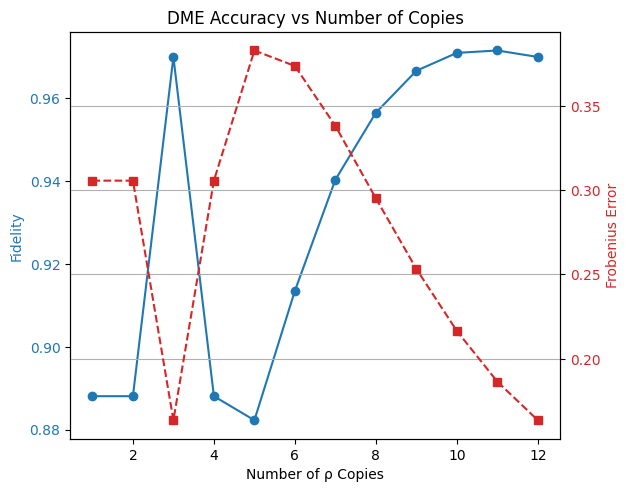

In [ ]:
copies, fidelities, errors = acc_vs_ncopies(dim=2, max_copies=12)
plot_acc_vs_ncopies(copies, fidelities, errors)

something curious is happening for rho = 3 consistently, cant figure out what - possibly due to the fact that it corresponds to exactly 4 qubits??

we are expecting the fidelity to go up as the number of copies goes up, and the error to go down (mostly observed)

this just compares how well the SWAP approximated unitary works with the actual unitary

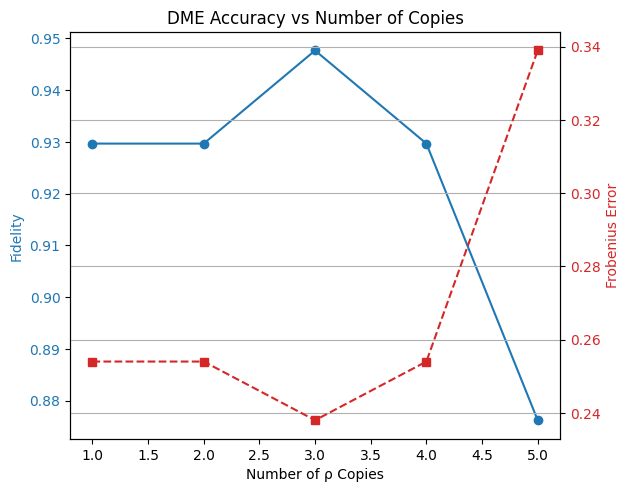

In [22]:
#dim = 2 -> 2 qubits per copy, max i got is 12 copies 13*2*26 qbits total
#dim = 4 -> 4 qbits per copy, max 5 so again 4*6=24 qubits
copies, fidelities, errors = acc_vs_ncopies(dim=4, max_copies=5)
plot_acc_vs_ncopies(copies, fidelities, errors)

In [ ]:
def acc_vs_ncopies_average(dim=2, t=2*np.pi, max_copies=5, trials=50, seed=None):
    if seed is not None:
        np.random.seed(seed)

    copies_range = list(range(1, max_copies + 1))
    fidelity_trials = {n: [] for n in copies_range}
    error_trials = {n: [] for n in copies_range}

    for _ in range(trials):
        sigma = generate_density_matrix(dim)
        rho = generate_density_matrix(dim)
        rho_qubits = rho.num_qubits
        sigma_q = sigma.num_qubits

        # True unitary evolution
        sigma_true = true_unitary_conjugation(rho, sigma, t)

        for n in copies_range:
            # Prepare σ ⊗ ρ ⊗ ... ⊗ ρ
            rho_tensor = rho
            for _ in range(n - 1):
                rho_tensor = rho_tensor.tensor(rho)
            joint = sigma.tensor(rho_tensor)

            # Generate DME circuit
            qc = densitymatrixexp_unitary(t=t, rho_copies=n,
                                          sigma_qubits=sigma_q, rho_qubits=rho_qubits)

            # Trace out all ρ copies
            idx = range(sigma_q, (n+1)*sigma_q)
            sigma_dme = evol_and_trace(joint, qc, idx)

            # Fidelity and error
            fid = state_fidelity(sigma_true, sigma_dme)
            err = np.linalg.norm(sigma_true.data - sigma_dme.data, ord='fro')

            fidelity_trials[n].append(fid)
            error_trials[n].append(err)

    # Compute means and standard deviations
    fidelities = [np.mean(fidelity_trials[n]) for n in copies_range]
    fidelities_std = [np.std(fidelity_trials[n]) for n in copies_range]
    errors = [np.mean(error_trials[n]) for n in copies_range]
    errors_std = [np.std(error_trials[n]) for n in copies_range]

    #print(errors)
    #print(errors_std)

    return copies_range, fidelities, fidelities_std, errors, errors_std


def plot_acc_vs_ncopies(copies, fidelities, fidelities_std, errors, errors_std):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Number of ρ Copies")
    ax1.set_ylabel("Fidelity", color="tab:blue")
    ax1.errorbar(copies, fidelities, yerr=fidelities_std, fmt='o-', color="tab:blue", capsize=5, label="Fidelity")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_ylim(0, 1.05)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Frobenius Error", color="tab:red")
    ax2.errorbar(copies, errors, yerr=errors_std, fmt='s--', color="tab:red", capsize=5, label="Frobenius Error")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.tight_layout()
    plt.title("Fidelity and Error (Avg over Random Matrices)")
    plt.grid(True)
    plt.show()


copies, fids, fid_std, errs, err_std = acc_vs_ncopies_average(
    dim=2,
    t=2 * np.pi,
    max_copies=8,
    trials=50,
    seed=42
)

plot_acc_vs_ncopies(copies, fids, fid_std, errs, err_std)

KeyboardInterrupt: 

In [23]:
def acc_vs_ncopies_eigenstructure(dim=2, max_copies=10, n_repeats=5):
    """
    Compares eigendecomposition differences.
    
    Args:
        dim (int): Dimension of the density matrices.
        max_copies (int): Max number of rho copies to test.
        n_repeats (int): How many random trials to average over.

    Returns:
        tuple:
            - copies_range (list[int])
            - avg_val_errors (list[float])
            - avg_vec_errors (list[float])
    """
    copies_range = list(range(1, max_copies + 1))
    avg_val_errors = []
    avg_vec_errors = []

    for n in copies_range:
        val_errors = []
        vec_errors = []

        for _ in range(n_repeats):
            _, _, eval1, eval2, evec1, evec2 = DME_POC(dim, n)

            # Sort eigenvalues/eigenvectors to compare properly
            idx1 = np.argsort(eval1)
            idx2 = np.argsort(eval2)

            eval1_sorted = np.array(eval1)[idx1]
            eval2_sorted = np.array(eval2)[idx2]

            evec1_sorted = np.array(evec1).T[idx1].T
            evec2_sorted = np.array(evec2).T[idx2].T

            # Eigenvalue error (L1 or L2)
            val_diff = np.linalg.norm(eval1_sorted - eval2_sorted, ord=2)
            val_errors.append(val_diff)

            # Eigenvector error (average L2 distance between matched vecs)
            vec_diff = 0
            for i in range(len(eval1)):
                v1 = evec1_sorted[:, i]
                v2 = evec2_sorted[:, i]
                phase = np.vdot(v1, v2)
                v2_aligned = v2 * np.sign(phase)
                vec_diff += np.linalg.norm(v1 - v2_aligned)
            vec_diff /= len(eval1)
            vec_errors.append(vec_diff)

        avg_val_errors.append(np.mean(val_errors))
        avg_vec_errors.append(np.mean(vec_errors))

    return copies_range, avg_val_errors, avg_vec_errors

def plot_dme_eigen_acc_vs_ncopies(copies, val_errors, vec_errors):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Number of ρ Copies")
    ax1.set_ylabel("Eigenvalue Error", color="tab:blue")
    ax1.plot(copies, val_errors, "o-", color="tab:blue", label="Eigenvalue Error")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Eigenvector Error", color="tab:orange")
    ax2.plot(copies, vec_errors, "s--", color="tab:orange", label="Eigenvector Error")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.tight_layout()
    plt.title("DME Eigenstructure Error vs Number of Copies")
    plt.grid(True)
    plt.show()

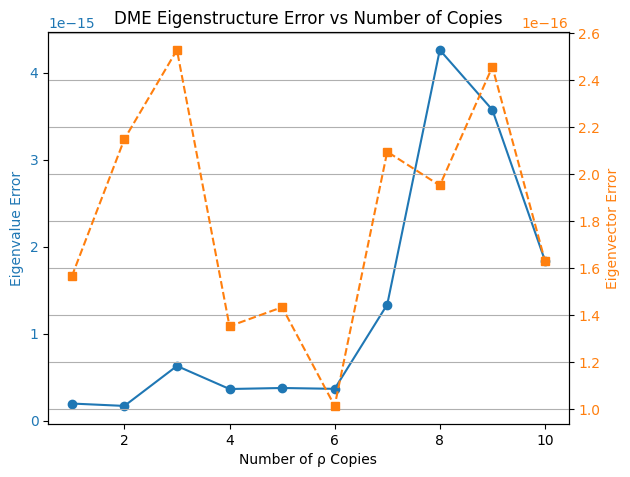

In [24]:
copies, val_errs, vec_errs = acc_vs_ncopies_eigenstructure(dim=2, max_copies=10, n_repeats=10)
plot_dme_eigen_acc_vs_ncopies(copies, val_errs, vec_errs)